In [27]:
#import modules
import pandas as pd

#list all csv files only
csv_files = ['Data/tns_search (14).csv', 'Data/tns_search (5).csv', 'Data/tns_search (6).csv', 'Data/tns_search (7).csv', 'Data/tns_search (8).csv', 'Data/tns_search (9).csv']


In [28]:
df_append = pd.DataFrame()

#append all files together
for file in csv_files:
    df_temp = pd.read_csv(file)
    df_append = pd.concat([df_append, df_temp], ignore_index=True)


In [29]:
df_append.to_csv("Data/ZTF_info.csv")

In [240]:
import pandas as pd

info = pd.read_csv("Data/ZTF_info.csv")


In [241]:
from astropy.time import Time

times = Time(list(info["Discovery Date (UT)"]), format = "iso", scale='utc')
times_JD = times.jd
times_JD_start = times_JD - 100
times_JD_end = times_JD + 500

In [242]:
from astropy.coordinates import SkyCoord
from astropy import units as u
ra_dec = SkyCoord(info["RA"].values, info["DEC"].values, unit=(u.hourangle, u.deg))
ra_degree = ra_dec.ra.degree
dec_degree = ra_dec.dec.degree

In [245]:
import numpy as np

nan_names = (info["Disc. Internal Name"].values != "nan")
downloading_info = np.column_stack((info["Disc. Internal Name"].values[nan_names], ra_degree[nan_names], dec_degree[nan_names], times_JD_start[nan_names], times_JD_end[nan_names]))
np.savetxt("ZTF_api/ZTF_info.txt", downloading_info, fmt = "%s")

In [8]:
import os

# Specify the directory where the files are located
directory = "Data/ATLAS_forced_photometry_data/"

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the file matches the pattern "SN xxxx.csv"
    if filename.startswith("SN ") and filename.endswith(".csv"):
        # Create the new filename by replacing the space with an underscore
        new_filename = filename.replace(" ", "_")
        
        # Get the full path of the old and new filenames
        old_file = os.path.join(directory, filename)
        new_file = os.path.join(directory, new_filename)
        
        # Rename the file
        os.rename(old_file, new_file)


In [59]:
import numpy as np

atlas_id = "SN_2019mtk"
atlas_data =  np.loadtxt(f"Data/ATLAS_forced_photometry_data/cleaned_and_stacked/{atlas_id}_atlas_fp_stacked_2_days.txt", delimiter = ",", dtype = str)

In [60]:
time = atlas_data[1:, 0].astype(np.float32)
flux = atlas_data[1:, 1].astype(np.float32)
fluxerr = atlas_data[1:, 2].astype(np.float32)
filter = atlas_data[1:, 3].astype(str)

In [61]:
delete_indices = np.where(fluxerr > 40)

time = np.delete(time, delete_indices)
flux = np.delete(flux, delete_indices)
fluxerr = np.delete(fluxerr, delete_indices)
filter = np.delete(filter, delete_indices)

filter_f1 = np.where(filter == "o")
filter_f2 = np.where(filter == "c")

time = np.concatenate((time[filter_f1], time[filter_f2]))
flux = np.concatenate((flux[filter_f1], flux[filter_f2]))
fluxerr = np.concatenate((fluxerr[filter_f1], fluxerr[filter_f2]))
filter = np.concatenate((["o"] * len(filter[filter_f1]), ["c"] * len(filter[filter_f2])))

filter_f1 = np.where(filter == "o")
filter_f2 = np.where(filter == "c")

In [1]:
def find_baseline(flux, filter_f1, filter_f2, window = 5):

    past_and_future_epochs =  {"Extrema f1":[], "Extrema f2":[]}

    for filter_number, filter_idx in enumerate([filter_f1, filter_f2]):
        flux_filter = flux[filter_idx]

        peak_idx = np.argmax(flux_filter)
        beginning_SN = 0

        first_section = flux_filter[:window]
        first_mean = np.mean(first_section)

        for idx in range(window, peak_idx, window):

            next_section = flux_filter[idx:idx + window]
            next_mean = np.mean(next_section)

            if np.abs(next_mean - first_mean) > window:
                beginning_SN = idx
                break

        past_and_future_epochs[f"Extrema f{filter_number + 1}"].append(beginning_SN)

    # Future
    for filter_number, filter_idx in enumerate([filter_f1, filter_f2]):

        flux_filter = flux[filter_idx]

        peak_idx = np.argmax(flux_filter)
        end_SN = -1

        last_section = flux_filter[-window:]
        last_mean = np.mean(last_section)

        for idx in range(-window, - (len(flux_filter) - peak_idx), -window):

            next_section = flux_filter[idx - window : idx]
            next_mean = np.mean(next_section)

            if np.abs(next_mean - last_mean) > window:
                end_SN = idx
                break
            
        past_and_future_epochs[f"Extrema f{filter_number + 1}"].append(end_SN)

    return past_and_future_epochs

In [63]:
past_and_future = find_baseline(flux, filter_f1, filter_f2)
past_and_future

{'Extrema f1': [5, -5], 'Extrema f2': [5, -5]}

In [2]:
def subtract_baseline(flux, filter_f1, filter_f2, past_and_future_epochs):

    if len(past_and_future_epochs["Extrema f1"]) != 0:

        baseline_f1 = np.concatenate((flux[filter_f1][:past_and_future_epochs["Extrema f1"][0]], flux[filter_f1][past_and_future_epochs["Extrema f1"][1]:]))
        average_flux_baseline_f1 = np.mean(baseline_f1)

        flux[filter_f1] -= average_flux_baseline_f1

    if len(past_and_future_epochs["Extrema f2"]) != 0:

        baseline_f2 = np.concatenate((flux[filter_f2][:past_and_future_epochs["Extrema f2"][0]], flux[filter_f2][past_and_future_epochs["Extrema f2"][1]:]))
        average_flux_baseline_f2 = np.mean(baseline_f2)

        flux[filter_f2] -= average_flux_baseline_f2

    return flux

In [65]:
flux = subtract_baseline(flux, filter_f1, filter_f2, past_and_future)

In [66]:
confident_detections = flux/fluxerr > 3

time = time[confident_detections]
flux = flux[confident_detections]
fluxerr = fluxerr[confident_detections]
filter = filter[confident_detections]

filter_f1 = np.where(filter == "o")
filter_f2 = np.where(filter == "c")

new_past_and_future = find_baseline(flux, filter_f1, filter_f2, 2)
new_past_and_future = np.concatenate((new_past_and_future["Extrema f1"], new_past_and_future["Extrema f2"]))

new_past_and_future

array([ 2, -2,  2, -1])

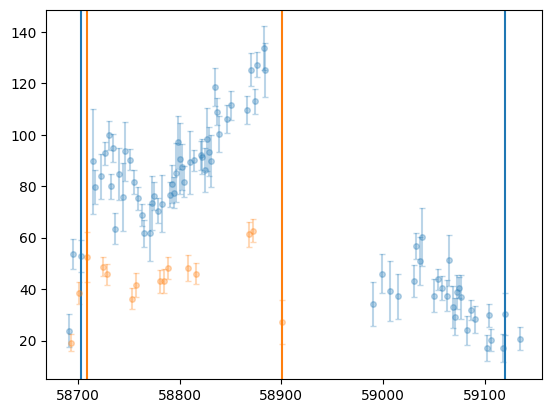

In [67]:
import matplotlib.pyplot as plt

plt.errorbar(time[filter_f1], flux[filter_f1], fluxerr[filter_f1], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue", alpha = 0.3)
plt.errorbar(time[filter_f2], flux[filter_f2], fluxerr[filter_f2], fmt = "o", markersize = 4, capsize = 2, color = "tab:orange", alpha = 0.3)

plt.axvline(time[filter_f1][new_past_and_future[0]], color = "tab:blue")
plt.axvline(time[filter_f2][new_past_and_future[2]], color = "tab:orange")


plt.axvline(time[filter_f1][new_past_and_future[1]], color = "tab:blue")
plt.axvline(time[filter_f2][new_past_and_future[3]], color = "tab:orange")

In [204]:
import numpy as np
import pandas as pd

# ztf_data =  np.load("forcedphotometry_req00387499_lc.txt")
name = "ZTF23absbzli"
with open(f"Data/ZTF_forced_photometry_data/raw/{name}.txt") as f:
    lines = (line for line in f if not line.startswith('#'))
    ztf_data = np.genfromtxt(lines, skip_header = 1, missing_values = "null", dtype = "str")


In [205]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz

def calculate_airmass(ra, dec, time):

    palomar = EarthLocation.of_site('Palomar')

    target = SkyCoord(ra, dec, unit = (u.hourangle, u.deg))
    time = Time(time, format = "jd")

    target_in_altaz = target.transform_to(AltAz(obstime = time, location = palomar))
    airmass = target_in_altaz.secz.value

    return airmass

In [206]:
time = np.array(ztf_data[:, 22])
differential_flux = np.array(ztf_data[:, 24])
differential_fluxerr = np.array(ztf_data[:, 25])
filter = np.array(ztf_data[:, 4])

# Retrieve supernova properties
ztf_information = pd.read_csv("Data/ZTF_info.csv")
SN_idx = np.where(ztf_information["Disc. Internal Name"] == name)

ra = ztf_information["RA"].values[SN_idx][0]
dec = ztf_information["DEC"].values[SN_idx][0]

infobitssci = np.array(ztf_data[:, 6]).astype(np.float32)
scisigpix = np.array(ztf_data[:, 9]).astype(np.float32)
sciinpseeing = np.array(ztf_data[:, 7]).astype(np.float32)
status = np.array(ztf_data[:, -1]).astype(str)

ccd = np.array(ztf_data[:, 2])
ccd_amplifier = np.array(ztf_data[:, 3])
ncalmatches = np.array(ztf_data[:, 15])

zero_point = np.array(ztf_data[:, 10])
zero_point_rms = np.array(ztf_data[:, 12])
reduced_chi_squared = np.array(ztf_data[:, 27])

# Filter out bad processing epochs
bad_observations = np.where(((status != "0") & (status != "56") & (status != "57") & (status != "62") & (status != "65")))[0]

# Filter out data with missing flux measurements
missing_data = np.where(differential_flux == "null")[0]

# Filter out data of a bad quality (possibly contaminated by clouds or the moon)
bad_infobitssci = np.where(infobitssci > 0)[0]
bad_scisigpix = np.where(scisigpix > 25)[0]
bad_sciinpseeing = np.where(sciinpseeing > 4)[0]

indices_to_delete = np.sort(np.unique(np.concatenate((bad_observations, missing_data, bad_infobitssci, bad_scisigpix, bad_sciinpseeing))))

time = np.delete(time, indices_to_delete).astype(np.float32)
differential_flux = np.delete(differential_flux, indices_to_delete).astype(np.float32)
differential_fluxerr = np.delete(differential_fluxerr, indices_to_delete).astype(np.float32)
filter = np.delete(filter, indices_to_delete)

ccd = np.delete(ccd, indices_to_delete).astype(np.float32)
ccd_amplifier = np.delete(ccd_amplifier, indices_to_delete).astype(np.float32)
ncalmatches = np.delete(ncalmatches, indices_to_delete).astype(np.float32)
zero_point = np.delete(zero_point, indices_to_delete).astype(np.float32)
zero_point_rms = np.delete(zero_point_rms, indices_to_delete).astype(np.float32)
reduced_chi_squared = np.delete(reduced_chi_squared, indices_to_delete).astype(np.float32)

filter_f1 = np.where(filter == "ZTF_r")
filter_f2 = np.where(filter == "ZTF_g")

# Quality cuts
airmass = calculate_airmass(ra, dec, time)
rcid = 4 * (ccd - 1) + ccd_amplifier - 1
ccd_threshold = pd.read_csv("Data/zp_thresholds_quadID.txt", comment = "#", delimiter = " |\t", header = None, engine = "python")
ccd_threshold.columns = ["index", "g", "ignore_1", "ignore_2", "r", "ignore_3", "ignore_4", "i"]

quality_cuts_f1 = np.where((filter == "ZTF_r") & ((zero_point > (26.65 - 0.15 * airmass)) | (zero_point_rms > 0.05) | (ncalmatches < 120) | (zero_point < (ccd_threshold["r"].iloc[rcid].to_numpy() - 0.15 * airmass))))[0]
quality_cuts_f2 = np.where((filter == "ZTF_g") & ((zero_point > (26.7 - 0.2 * airmass)) | (zero_point_rms > 0.06) | (ncalmatches < 80) | (zero_point < (ccd_threshold["g"].iloc[rcid].to_numpy() - 0.2 * airmass))))[0]

indices_to_delete = np.sort(np.unique(np.concatenate((quality_cuts_f1, quality_cuts_f2))))

time = np.delete(time, indices_to_delete).astype(np.float32) -  2400000.5
differential_flux = np.delete(differential_flux, indices_to_delete).astype(np.float32) / 10
differential_fluxerr = np.delete(differential_fluxerr, indices_to_delete).astype(np.float32) / 10
filter = np.delete(filter, indices_to_delete)
reduced_chi_squared = np.delete(reduced_chi_squared, indices_to_delete).astype(np.float32)

filter_f1 = np.where(filter == "ZTF_r")
filter_f2 = np.where(filter == "ZTF_g")

In [207]:
time = np.concatenate((time[filter_f1], time[filter_f2]))
differential_flux = np.concatenate((differential_flux[filter_f1], differential_flux[filter_f2]))
differential_fluxerr = np.concatenate((differential_fluxerr[filter_f1], differential_fluxerr[filter_f2]))
zero_point = np.concatenate((zero_point[filter_f1], zero_point[filter_f2]))
reduced_chi_squared = np.concatenate((reduced_chi_squared[filter_f1], reduced_chi_squared[filter_f2]))
filter = np.concatenate((["r"] * len(filter[filter_f1]), ["g"] * len(filter[filter_f2])))

filter_f1 = np.where(filter == "r")
filter_f2 = np.where(filter == "g")

len(differential_fluxerr), len(zero_point)

(139, 139)

In [208]:
past_and_future = find_baseline(differential_flux, filter_f1, filter_f2)
differential_flux = subtract_baseline(differential_flux, filter_f1, filter_f2, past_and_future)

past_and_future = np.concatenate((past_and_future["Extrema f1"], past_and_future["Extrema f2"]))

In [209]:
def check_flux_uncertainties(fluxerr, reduced_chi_squared):

    average_reduced_chi_squared = np.mean(reduced_chi_squared)

    if not np.isclose(average_reduced_chi_squared, 1, 0.5):

        fluxerr *= np.sqrt(average_reduced_chi_squared)

    return fluxerr

In [210]:
differential_fluxerr = check_flux_uncertainties(differential_fluxerr, reduced_chi_squared)

In [211]:
confident_detections = differential_flux/differential_fluxerr > 3

# time = time[confident_detections]
# differential_flux = differential_flux[confident_detections]
# differential_fluxerr = differential_fluxerr[confident_detections]
# filter = filter[confident_detections]

confident_filter_f1 = np.where(filter[confident_detections] == "r")
confident_filter_f2 = np.where(filter[confident_detections] == "g")

In [212]:
new_past_and_future = find_baseline(differential_flux, filter_f1, filter_f2, 2)
new_past_and_future = np.concatenate((new_past_and_future["Extrema f1"], new_past_and_future["Extrema f2"]))

# time = np.concatenate((time[filter_f1][boundaries[0] : boundaries[1]], time[filter_f2][boundaries[2] : boundaries[3]]))
# flux = np.concatenate((flux[filter_f1][boundaries[0] : boundaries[1]], flux[filter_f2][boundaries[2] : boundaries[3]]))
# fluxerr = np.concatenate((fluxerr[filter_f1][boundaries[0] : boundaries[1]], fluxerr[filter_f2][boundaries[2] : boundaries[3]]))
# filters = np.concatenate((filters[filter_f1][boundaries[0] : boundaries[1]], filters[filter_f2][boundaries[2] : boundaries[3]]))

new_past_and_future

array([ 2, -4,  2, -2])

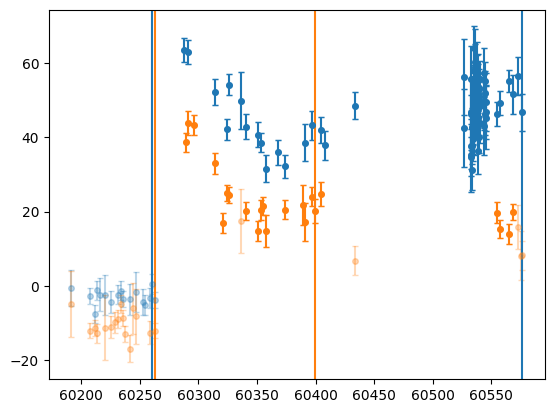

In [213]:
import matplotlib.pyplot as plt

plt.errorbar(time[filter_f1], differential_flux[filter_f1], differential_fluxerr[filter_f1], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue", alpha = 0.3)
plt.errorbar(time[filter_f2], differential_flux[filter_f2], differential_fluxerr[filter_f2], fmt = "o", markersize = 4, capsize = 2, color = "tab:orange", alpha = 0.3)

plt.errorbar(time[confident_detections][confident_filter_f1], differential_flux[confident_detections][confident_filter_f1], differential_fluxerr[confident_detections][confident_filter_f1], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue")
plt.errorbar(time[confident_detections][confident_filter_f2], differential_flux[confident_detections][confident_filter_f2], differential_fluxerr[confident_detections][confident_filter_f2], fmt = "o", markersize = 4, capsize = 2, color = "tab:orange")

plt.axvline(time[filter_f1][past_and_future[0]], color = "tab:blue")
plt.axvline(time[filter_f2][past_and_future[2]], color = "tab:orange")

plt.axvline(time[filter_f1][past_and_future[1]], color = "tab:blue")
plt.axvline(time[filter_f2][past_and_future[3]], color = "tab:orange")

# plt.scatter(time[past_and_future["Past Future f1"]], differential_flux[past_and_future["Past Future f1"]], c = "tab:blue")
# plt.scatter(time[past_and_future["Past Future f2"]], differential_flux[past_and_future["Past Future f2"]], c = "tab:orange")

plt.show()

In [ ]:
from src.data_processing import ztf_load_data
time, flux, fluxerr, filters, boundaries = ztf_load_data("ZTF19acbjddp")
boundaries

array([ 2, -2,  2, -2])

In [15]:
plt.errorbar(time[filter_f2], differential_flux[filter_f2], differential_fluxerr[filter_f2], fmt = "o", markersize = 4, capsize = 2, color = "tab:orange", alpha = 0.3)
plt.axvline(time[filter_f2][past_and_future["Extrema f2"][0]], color = "tab:orange")
plt.axvline(time[filter_f2][past_and_future["Extrema f2"][1]], color = "tab:orange")


NameError: name 'plt' is not defined

inf 2.4416173
inf 2.6553876


/tmp/ipykernel_1114/3317446921.py:13: RuntimeWarning: divide by zero encountered in float_scalars
  previous_slope = np.abs((flux_filter[0] - flux_filter[1]) / (time_filter[0] - time_filter[1]))
/tmp/ipykernel_1114/3317446921.py:17: RuntimeWarning: divide by zero encountered in float_scalars
  next_slope = np.abs((flux_filter[0] - flux_filter[cut_idx]) / (time_filter[0] - time_filter[cut_idx]))
/tmp/ipykernel_1114/3317446921.py:19: RuntimeWarning: invalid value encountered in float_scalars
  if np.abs(next_slope - previous_slope) > 0.2:
/tmp/ipykernel_1114/3317446921.py:36: RuntimeWarning: divide by zero encountered in float_scalars
  previous_slope = np.abs((flux_filter[-1] - flux_filter[-2]) / (time_filter[-1] - time_filter[-2]))


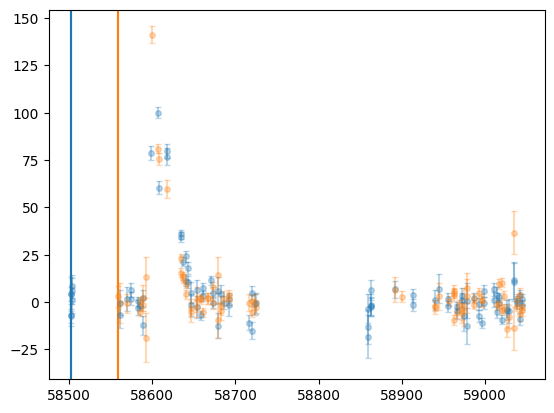

In [234]:
# baseline = np.concatenate((differential_flux[filter_f2][:beginning_SN], differential_flux[filter_f2][end_SN:]))
# average_flux = np.mean(baseline)
# differential_flux[filter_f2] -= average_flux

past_and_future = find_baseline(time, differential_flux, filter_f1, filter_f2)


plt.errorbar(time[filter_f1], differential_flux[filter_f1], differential_fluxerr[filter_f1], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue", alpha = 0.3)
plt.errorbar(time[filter_f2], differential_flux[filter_f2], differential_fluxerr[filter_f2], fmt = "o", markersize = 4, capsize = 2, color = "tab:orange", alpha = 0.3)


plt.axvline(time[filter_f1][past_and_future[0]], color = "tab:blue")
plt.axvline(time[filter_f2][past_and_future[1]], color = "tab:orange")


plt.axvline(time[filter_f1][past_and_future[2]], color = "tab:blue")
plt.axvline(time[filter_f2][past_and_future[3]], color = "tab:orange")

# print(baseline)
# print(average_flux)

In [235]:
past_and_future

[3, 0, 1, 0, -2, 0, -2, 0]

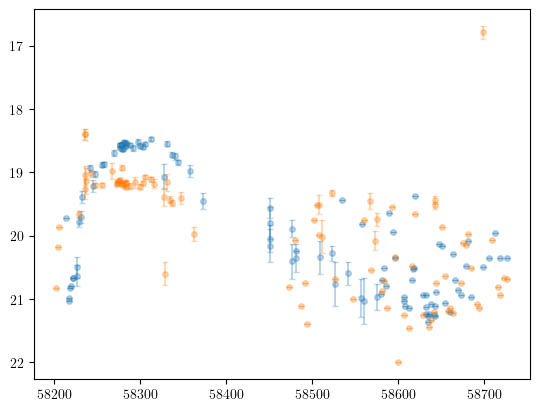

In [16]:
plt.errorbar(time[filter_f1], mag[filter_f1], magerr[filter_f1], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue", alpha = 0.3)
plt.errorbar(time[filter_f2], mag[filter_f2], magerr[filter_f2], fmt = "o", markersize = 4, capsize = 2, color = "tab:orange", alpha = 0.3)

plt.gca().invert_yaxis()

plt.show()

In [ ]:
from src.data_processing import ztf_load_data

ztf_names_sn_Ia_CSM = np.loadtxt("Data/ZTF_SNe_Ia_CSM.txt", delimiter = ",", dtype = "str")
ztf_names_sn_IIn = np.loadtxt("Data/ZTF_SNe_IIn.txt", delimiter = ",", dtype = "str")
ztf_names = np.concatenate((ztf_names_sn_Ia_CSM, ztf_names_sn_IIn))

for SN_name in ztf_names:

    time, flux, fluxerr, filters, boundaries = ztf_load_data(SN_name)
    print(SN_name, boundaries)

ZTF24aaotlsk [ 2 -2  2 -2]
ZTF24aadqwju [ 2 -2  2 -2]
ZTF23abgnvya [ 4 -2  2 -2]
ZTF23aaynmrz [ 2 -2  2 -2]
ZTF23aatabje [ 4 -2  2 -2]
ZTF23aagpjyp [ 2 -4  2 -2]
ZTF22ablxcrh [ 2 -2  2 -4]
ZTF22abfyqzz [ 2 -2  0 -6]
ZTF20acqikeh [ 2 -2  2 -2]
ZTF20abqkbfx [ 2 -6  2 -4]
ZTF19acbjddp [  2 -14   2  -8]
ZTF19aaeoqst [ 2 -2  0 -4]
ZTF18abuatfp [ 2 -4  4 -2]
ZTF24abeivan [ 2 -2  2 -2]
ZTF24aatjphv [ 2 -2  2 -2]
ZTF24aamiomv [ 2 -2  0 -2]
ZTF24aaleeji [ 2 -2  2 -2]
ZTF24aaisnlp [ 2 -2  2 -2]
ZTF24aaifila [ 2 -2  2 -2]
ZTF24aafqxmg [ 0 -2  0 -4]
ZTF24aaerzgz [ 2 -2  2 -4]
ZTF23absbzli [ 0 -2  2 -2]
ZTF23absdibx [ 2 -2  2 -2]
ZTF23abqimmw [ 2 -4  2 -2]
ZTF23abpznvm [ 2 -2  2 -2]
ZTF23abomtge [ 2 -2  2 -2]
ZTF23abjvuwc [ 2 -2  2 -2]
ZTF23ablutgq [ 0 -2  0 -2]
ZTF23abjikaf [ 2 -2  2 -2]
ZTF23abkhwgb [ 2 -2  2 -2]
ZTF23aaxldkr [ 0 -2  2 -2]
ZTF23aavtugd [ 2 -4  2 -2]
ZTF23aavvckk [ 2 -2  2 -2]
ZTF23aavmthe [ 2 -2  2 -4]
ZTF23aatdcey [ 2 -2  2 -2]
ZTF23aaquolj [ 2 -2  2 -2]
ZTF23aaoyxjb [ 2 -2  2 -

In [ ]:
import numpy as np
from src.parameter_estimation import light_curve_one_peak, light_curve_two_peaks

# Only consider data belonging to the supernova explosion
time = np.concatenate((time[boundaries[0] : boundaries[2] + 1], time[boundaries[1] : boundaries[3] + 1]))
flux = np.concatenate((flux[boundaries[0] : boundaries[2] + 1], flux[boundaries[1] : boundaries[3] + 1]))
filters = np.concatenate((filters[boundaries[0] : boundaries[2] + 1], filters[boundaries[1] : boundaries[3] + 1]))

f1_values = np.where(filters == "r")

# Shift the light curve so that the main peak is at time = 0 MJD
peak_main_idx = np.argmax(flux[f1_values])
peak_time = np.copy(time[peak_main_idx])
peak_flux = np.copy(flux[peak_main_idx])

time -= peak_time

amount_fit = 100
time_fit = np.concatenate((np.linspace(-500, 500, amount_fit), np.linspace(-500, 500, amount_fit)))
f1_values_fit = np.arange(amount_fit)
f2_values_fit = np.arange(amount_fit) + amount_fit

parameter_values = np.load(f"Data/Analytical_parameters/ZTF/one_peak/ZTF22abhwlnm_parameters_OP.npy")

flux_fit = light_curve_one_peak(time_fit, parameter_values[:14], peak_flux, f1_values_fit, f2_values_fit)

import matplotlib.pyplot as plt

plt.scatter(time_fit, flux_fit)

ValueError: attempt to get argmax of an empty sequence

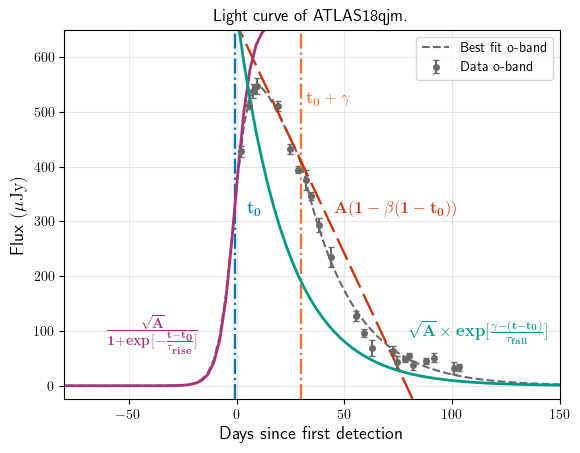

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

from src.data_processing import ztf_load_data, atlas_load_data
from src.parameter_estimation import light_curve_one_peak, light_curve_two_peaks, augment_data, find_extrema, isolate_second_peak

plt.rcParams['text.usetex'] = True

time, flux, fluxerr, filters = atlas_load_data("ATLAS18qjm")
f1, f2 = "o", "c"
parameter_values = np.load(f"Data/Analytical_parameters/ATLAS/one_peak/ATLAS18qjm_parameters_OP.npy")

filter_f1 = np.where(filters == f1)
filter_f2 = np.where(filters == f2)

peak_main_idx = np.argmax(flux[filter_f1])
peak_time = np.copy(time[peak_main_idx])
peak_flux = np.copy(flux[peak_main_idx])

time -= peak_time

amount_fit = 100

time_fit = np.concatenate((np.linspace(time.min() - 85, time.max() + 85, amount_fit), np.linspace(time.min() - 85, time.max() + 85, amount_fit)))
f1_values_fit = np.arange(amount_fit)
f2_values_fit = np.arange(amount_fit) + amount_fit

flux_fit = light_curve_one_peak(time_fit, parameter_values, peak_flux, f1_values_fit, f2_values_fit)

rise_parameter = peak_flux * (10 ** parameter_values[0]) / (1 + np.exp(-(time_fit  + peak_time - sorted(time + peak_time)[1] - (parameter_values[1] + peak_time - sorted(time + peak_time)[1])) / (10 ** parameter_values[2])))
fall_parameter = peak_flux * (10 ** parameter_values[0]) * (np.exp( ((10 ** parameter_values[0]) - (time_fit  + peak_time - sorted(time + peak_time)[1] - (parameter_values[1] + peak_time - sorted(time + peak_time)[1]))) / (10 ** parameter_values[5]))) 
beta = peak_flux * (10 ** parameter_values[0]) * (1 - parameter_values[4] * (time_fit  + peak_time - sorted(time + peak_time)[1] - (parameter_values[1] + peak_time - sorted(time + peak_time)[1])))

r_values = np.where(filters == f1)
plt.errorbar(time[r_values] + peak_time - sorted(time + peak_time)[1], flux[r_values], yerr = fluxerr[r_values], fmt = "o", markersize = 4, capsize = 2, color = "dimgrey", label = f"Data {f1}-band")
plt.plot(time_fit[f1_values_fit] + peak_time - sorted(time + peak_time)[1], flux_fit[f1_values_fit], linestyle = "--", linewidth = 1.5, color = "dimgrey", label = f"Best fit {f1}-band")

plt.axvline(parameter_values[1] + peak_time - sorted(time + peak_time)[1], linewidth = 1.7, linestyle = "-.", color = "#0077BB")
plt.text(5, 315, r"$\mathbf{t_{0}}$", fontsize = "large", color = "#0077BB")

plt.axvline(10 ** (parameter_values[3]) + parameter_values[1] + peak_time - sorted(time + peak_time)[1], linewidth = 1.7, linestyle = "-.", color = "#EE7733")
plt.text(32, 515, r"$\mathbf{t_{0}} + \mathbf{\gamma}$", fontsize = "large", color = "#EE7733")

plt.plot(time_fit[f1_values_fit] + peak_time - sorted(time + peak_time)[1], beta[f1_values_fit], linewidth = 1.7, linestyle = (5, (10, 3)), color = "#CC3311")
plt.text(45, 315, r"$ \mathbf{A (1 - \beta(1 - t_0))}$", fontsize = "large", color = "#CC3311")

plt.plot(time_fit[f1_values_fit] + peak_time - sorted(time + peak_time)[1], rise_parameter[f1_values_fit], linewidth = 2, linestyle = "-", color = "#AA3377")
plt.text(-60, 90, r"$ \mathbf{\frac{\sqrt{A}}{1 + \mathbf{exp}[ - \frac{t - t_{0}}{\mathbf{\tau _{rise}}}] }}$", fontsize = "x-large", color = "#AA3377")          

plt.plot(time_fit[f1_values_fit] + peak_time - sorted(time + peak_time)[1], fall_parameter[f1_values_fit], linewidth = 2, linestyle = "-", color = "#009988")
plt.text(80, 90, r"$ \mathbf{\sqrt{A}\times \mathbf{exp}[ \frac{\mathbf{\gamma} - (t - t_{0})}{\mathbf{\tau _{fall}}}]}$", fontsize = "large", color = "#009988")

colours = {"blue":"#0077BB", "orange": "EE7733", "green":"#009988", "purple":"#AA3377", "red":"#CC3311"}

plt.xlabel("Days since first detection", fontsize = 13)
plt.ylabel("Flux $(\mathrm{\mu Jy})$", fontsize = 13)
plt.title(f"Light curve of ATLAS18qjm.")
plt.grid(alpha = 0.3) 
plt.xlim([-80, 150])
plt.ylim([-25, 650])
plt.legend()
# plt.savefig(f"Presentation/explenation_fitting_parameters.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [ ]:
from src.data_processing import ztf_load_data, atlas_micro_flux_to_magnitude
import numpy as np
from src.parameter_estimation import light_curve_two_peaks

time, flux, _, filters = ztf_load_data("ZTF21abhqqfa")

parameter_values = np.load(f"Data/Analytical_parameters/ZTF/two_peaks/ZTF21abhqqfa_parameters_TP.npy")

f1_values = np.where(filters == "r")

# Shift the light curve so that the main peak is at time = 0 MJD
peak_main_idx = np.argmax(flux[f1_values])
peak_time = np.copy(time[peak_main_idx])
peak_flux = np.copy(flux[peak_main_idx])

time -= peak_time

amount_fit = 1000
time_fit = np.concatenate((np.linspace(time.min() - 75, time.max() + 75, amount_fit), np.linspace(time.min() - 75, time.max() + 75, amount_fit)))
f1_values_fit = np.arange(amount_fit)
f2_values_fit = np.arange(amount_fit) + amount_fit

flux_fit = light_curve_two_peaks(time_fit, parameter_values, peak_flux, f1_values_fit, f2_values_fit)

magnitude_fit, _ = atlas_micro_flux_to_magnitude(flux_fit, flux_fit)

time_fit += peak_time

# In filter 1
peak_fit_idx_f1 = np.argmax(flux_fit[f1_values_fit])
peak_time_fit_f1 = np.copy(time_fit[peak_fit_idx_f1])
peak_flux_fit_f1 = np.copy(flux_fit[peak_fit_idx_f1])
time_fit_f1 = time_fit - peak_time_fit_f1

# Peak magnitude
peak_magnitude_f1 = magnitude_fit[peak_fit_idx_f1]
print(peak_magnitude_f1)

# Rise time 
explosion_time_f1 = np.argmin(np.abs(flux_fit[f1_values_fit][:peak_fit_idx_f1] - 0.1))
rise_time_f1 = time_fit_f1[peak_fit_idx_f1] - time_fit_f1[explosion_time_f1]

# Magnitude difference peak - 10 days before
ten_days_before_peak_f1 = np.argmin(np.abs(time_fit_f1[f1_values_fit] + 10))
ten_days_magnitude_f1 = magnitude_fit[ten_days_before_peak_f1]
ten_days_magnitude_difference_f1 = np.abs(peak_magnitude_f1 - ten_days_magnitude_f1)

# Magnitude difference peak - 15 days after
fifteen_days_after_peak_f1 = np.argmin(np.abs(time_fit_f1[f1_values_fit] - 15))
fifteen_days_magnitude_f1 = magnitude_fit[fifteen_days_after_peak_f1]
fifteen_days_magnitude_difference_f1 = np.abs(peak_magnitude_f1 - fifteen_days_magnitude_f1)

# Magnitude difference peak - 30 days after
thirty_days_after_peak_f1 = np.argmin(np.abs(time_fit_f1[f1_values_fit] - 30))
thirty_days_magnitude_f1 = magnitude_fit[thirty_days_after_peak_f1]
thirty_days_magnitude_difference_f1 = np.abs(peak_magnitude_f1 - thirty_days_magnitude_f1)
print(thirty_days_magnitude_f1)
print(thirty_days_magnitude_difference_f1)

# Duration above half of the peak flux
half_peak_flux_f1 = np.argmin(np.abs(flux_fit[f1_values_fit][peak_fit_idx_f1:] - peak_flux_fit_f1 * 0.5)) + peak_fit_idx_f1
half_peak_time_f1 = time_fit_f1[half_peak_flux_f1]

# Duration above a fifth of the peak flux
fifth_peak_flux_f1 = np.argmin(np.abs(flux_fit[f1_values_fit][peak_fit_idx_f1:] - peak_flux_fit_f1 * 0.2)) + peak_fit_idx_f1
fifth_peak_time_f1 = time_fit_f1[fifth_peak_flux_f1]

18.142105675000522
19.14483593179231
1.0027302567917893


In [ ]:
from src.parameter_reduction import calculate_global_parameters
import numpy as np 

parameter_values = np.load(f"Data/Analytical_parameters/ZTF/two_peaks/ZTF21abhqqfa_parameters_TP.npy")
calculate_global_parameters("ZTF21abhqqfa", "ZTF", 2, parameter_values)

array([18.14210568, 57.90610923,  0.83527423,  0.68792727,  1.00273026,
       21.2987988 , 42.5975976 , 18.38816932, 62.23242774,  0.81812933,
        0.98857826,  1.21132732,  6.98866836, 33.94496059])

In [3]:
import numpy as np 

ztf_names_sn_Ia_CSM = np.loadtxt("Data/ZTF_SNe_Ia_CSM.txt", delimiter = ",", dtype = "str")
ztf_names_sn_IIn = np.loadtxt("Data/ZTF_SNe_IIn.txt", delimiter = ",", dtype = "str")
ztf_names = np.concatenate((ztf_names_sn_Ia_CSM, ztf_names_sn_IIn))

atlas_names_sn_Ia_CSM = np.loadtxt("Data/ATLAS_SNe_Ia_CSM.txt", delimiter = ",", dtype = "str")
atlas_names_sn_IIn = np.loadtxt("Data/ATLAS_SNe_IIn.txt", delimiter = ",", dtype = "str")
atlas_names = np.concatenate((atlas_names_sn_Ia_CSM, atlas_names_sn_IIn))

In [54]:
for name in ztf_names:

    time, flux, fluxerr, filters, boundaries = ztf_load_data(name)

    filter_f1 = np.where(filters == "r")
    filter_f2 = np.where(filters == "g")

    past_and_future = find_baseline(time, flux, filter_f1, filter_f2)

    np.save(f"Data/ZTF_forced_photometry_data/processed/{name}_extremes.npy", past_and_future["SN extremes"])

/tmp/ipykernel_5341/2220984027.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  m = np.abs((flux_filter[-1] - flux_filter[cut_idx]) / (time_filter[-1] - time_filter[cut_idx]))
/tmp/ipykernel_5341/2220984027.py:24: RuntimeWarning: divide by zero encountered in float_scalars
  m = np.abs((flux_filter[0] - flux_filter[cut_idx]) / (time_filter[0] - time_filter[cut_idx]))


In [8]:
for name in atlas_names:

    time, flux, fluxerr, filters, boundaries = atlas_load_data(name)

    filter_f1 = np.where(filters == "o")
    filter_f2 = np.where(filters == "c")

    past_and_future = find_baseline(time, flux, filter_f1, filter_f2)

    np.save(f"Data/ATLAS_forced_photometry_data/processed/{name}_extremes.npy", past_and_future["SN extremes"])

In [ ]:
plt.rcParams['text.usetex'] = True

time, flux, fluxerr, filters, boundaries = ztf_load_data("ZTF23aansdlc")
f1, f2 = "r", "g"
parameter_values = np.load(f"Data/Analytical_parameters/ZTF/two_peaks/ZTF23aansdlc_parameters_TP.npy")

if time[boundaries[0] + 1] < time[boundaries[1] + 1]:
    time_first_detection = time[boundaries[0] + 1]

else: 
    time_first_detection = time[boundaries[1] + 1]

filter_f1 = np.where(filters == f1)
filter_f2 = np.where(filters == f2)

time = np.concatenate((time[filter_f1][boundaries[0] : boundaries[1]], time[filter_f2][boundaries[2] : boundaries[3]]))
flux = np.concatenate((flux[filter_f1][boundaries[0] : boundaries[1]], flux[filter_f2][boundaries[2] : boundaries[3]]))
fluxerr = np.concatenate((fluxerr[filter_f1][boundaries[0] : boundaries[1]], fluxerr[filter_f2][boundaries[2] : boundaries[3]]))
filters = np.concatenate((filters[filter_f1][boundaries[0] : boundaries[1]], filters[filter_f2][boundaries[2] : boundaries[3]]))

f1_values = np.where(filters == f1)
f2_values = np.where(filters == f2)

peak_main_idx = np.argmax(flux[f1_values])
peak_time = np.copy(time[peak_main_idx])
peak_flux = np.copy(flux[peak_main_idx])

time -= peak_time

amount_fit = 100

time_fit = np.concatenate((np.linspace(time.min() - 30, time.max() + 30, amount_fit), np.linspace(time.min() - 30, time.max() + 30, amount_fit)))
f1_values_fit = np.arange(amount_fit)
f2_values_fit = np.arange(amount_fit) + amount_fit

flux_fit = light_curve_two_peaks(time_fit, parameter_values, peak_flux, f1_values_fit, f2_values_fit)

amount_aug = 70

time_aug, flux_aug, fluxerr_aug, filters_aug = augment_data("ZTF", peak_time, amount_aug)

f1_values_aug = np.where(filters_aug == f1)
f2_values_aug = np.where(filters_aug == f2)

extrema_f1, peak_width_f1, extrema_f2, peak_width_f2 = find_extrema(time_aug, flux_aug, fluxerr_aug, f1_values_aug, f2_values_aug)
time_peak, flux_peak, fluxerr_peak, filters_peak = isolate_second_peak(f1, extrema_f1, peak_width_f1, 
                                                                               extrema_f2, peak_width_f2, time_aug, f1_values_aug, f2_values_aug)

f1_values_peak = np.where(filters_peak == f1)
f2_values_peak = np.where(filters_peak == f2)

# Inital guess of the parameters (amplitude, mean, standard deviation)
# If in both filters a second peak is detected
if f1 in filters and extrema_f1[2] != -1 and f2 in filters and extrema_f2[2] != -1:
    guess_parameters = np.array([1, time_aug[f1_values_aug][extrema_f1][2], peak_width_f1, 
                                flux_aug[f2_values_aug][extrema_f2][2] / flux_aug[f1_values_aug][extrema_f1][2], 
                                time_aug[f2_values_aug][extrema_f2][2] / time_aug[f1_values_aug][extrema_f1][2], 
                                peak_width_f2 / peak_width_f1])

# If only in one peak a second peak is detected
else:
    if f1 in filters and extrema_f1[2] != -1:
        guess_parameters = np.array([1, time_aug[f1_values_aug][extrema_f1][2], peak_width_f1, 1, 1, 1])

    elif f2 in filters and extrema_f2[2] != -1:
        guess_parameters = np.array([1, time_aug[f2_values_aug][extrema_f2][2], peak_width_f2, 1, 1, 1])

down_bound = parameter_bounds_gaussian[0]
up_bound = parameter_bounds_gaussian[1]

second_peak_parameters, _ = curve_fit(second_peak, time_peak, flux_peak, p0 = guess_parameters, sigma = fluxerr_peak, bounds = parameter_bounds_gaussian)
flux_peak = second_peak_fit(time, *second_peak_parameters)

flux -= flux_peak

parameter_values_OP, _ = find_parameters_one_peak("ZTF23aansdlc", "ZTF")
flux_OP_fit = light_curve_one_peak(time_fit, parameter_values_OP, peak_flux, f1_values_fit, f2_values_fit)

flux += flux_peak

time += peak_time
time_fit += peak_time
time_aug += peak_time
time_peak += peak_time

time -= time_first_detection
time_fit -= time_first_detection
time_aug -= time_first_detection
time_peak -= time_first_detection

# %%

r_values = np.where(filters == f1)
plt.errorbar(time[r_values], flux[r_values], yerr = fluxerr[r_values], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue", label = f"Residual data r-band")
# plt.errorbar(time_peak[f1_values_peak], flux_peak[9:12], yerr = fluxerr_peak[f1_values_peak], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue", label = f"Data second peak r-band")
plt.plot(time_fit[f1_values_fit], flux_OP_fit[f1_values_fit], linestyle = "--", linewidth = 2, color = "tab:blue", label = f"Best fit residual data {f1}-band")
# plt.plot(time[f1_values], flux_peak[f1_values], linewidth = 2, linestyle = ":", color = "black", label = "Best fit second peak r-band")

# plt.fill_between(time_aug[f1_values_aug], flux_aug[f1_values_aug] - fluxerr_aug[f1_values_aug], flux_aug[f1_values_aug] + fluxerr_aug[f1_values_aug], color = "tab:blue", alpha = 0.15, label = "Error approximation r-band")
# plt.plot(time_aug[f1_values_aug], flux_aug[f1_values_aug], linewidth = 2, color = "tab:blue", zorder = 5, label = "Flux approximation r-band")

# plt.scatter(time_aug[f1_values_aug][extrema_f1][::2], flux_aug[f1_values_aug][extrema_f1][::2], s = 200, marker = "*", c = "tab:orange", edgecolors = "black", label = "Extrema r-band" , zorder = 10)
# plt.scatter(time_aug[f1_values_aug][extrema_f1][1], flux_aug[f1_values_aug][extrema_f1][1], s = 200, marker = "*", c = "tab:orange", edgecolors = "black", zorder = 10)

plt.xlabel("Days since first detection", fontsize = 13)
plt.ylabel("Flux $(\mu Jy)$", fontsize = 13)
plt.title(f"Best fit residual light curve of ZTF23aansdlc.")
plt.grid(alpha = 0.3) 
# plt.xlim([-4, 54])
# plt.ylim([-25, 425])
plt.legend()
plt.savefig(f"Presentation/fitted_lightcurve_TP_residual.png", dpi = 300, bbox_inches = "tight")
plt.show()
